In [1]:
%cd ..
%ls

/home/nas3_userJ/dmkim/OnlineTSAD
cfgs/         data/  Exp/   models/   plots/    test.py*   utils/  wandb/
checkpoints/  EDA/   logs/  outputs/  results/  train.py*  Vis/


In [2]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_anomaly

import warnings
from data.load_data import DataFactory
from Exp.ReconBaselines import *

from easydict import EasyDict as edict
import yaml
import re

warnings.filterwarnings("ignore")

In [3]:
# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})
cfg['dataset'] = 'SWaT'

In [4]:
args = prepare_arguments(cfg)
args.model.latent_dim = 128
args.window_size = 12
args.eval_batch_size = 1
args.dataset = "SWaT"
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-03-27 17:41:07,951] Configurations: {'exp_id': 'MLP_SWaT', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT', 'log_path': './logs/MLP_SWaT', 'output_path': './outputs/MLP_SWaT', 'plot_path': './plots/MLP_SWaT', 'result_path': './results/MLP_SWaT', 'thresholding': 'oracle', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}
[2023-03-27 17:41:07,952] Preparing SWaT dataset...
[2023-03-27 17:41:07,953] current location: /home/nas3_userJ/dmkim/OnlineTSAD
[2023-03-27 17:41:07,954] home dir: .
[2023-03-27 17:41:07,955] Preparing SWaT ...


{'exp_id': 'MLP_SWaT', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT', 'log_path': './logs/MLP_SWaT', 'output_path': './outputs/MLP_SWaT', 'plot_path': './plots/MLP_SWaT', 'result_path': './results/MLP_SWaT', 'thresholding': 'oracle', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}


[2023-03-27 17:41:17,462] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-03-27 17:41:17,540] Complete.
[2023-03-27 17:41:17,541] Preparing dataloader...
[2023-03-27 17:41:18,162] total train dataset- 7763, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-03-27 17:41:18,164] total test dataset- 37493, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-03-27 17:41:18,165] Complete.


(496800, 51) (496800,) (449916, 51) (449916,)


## Visualize

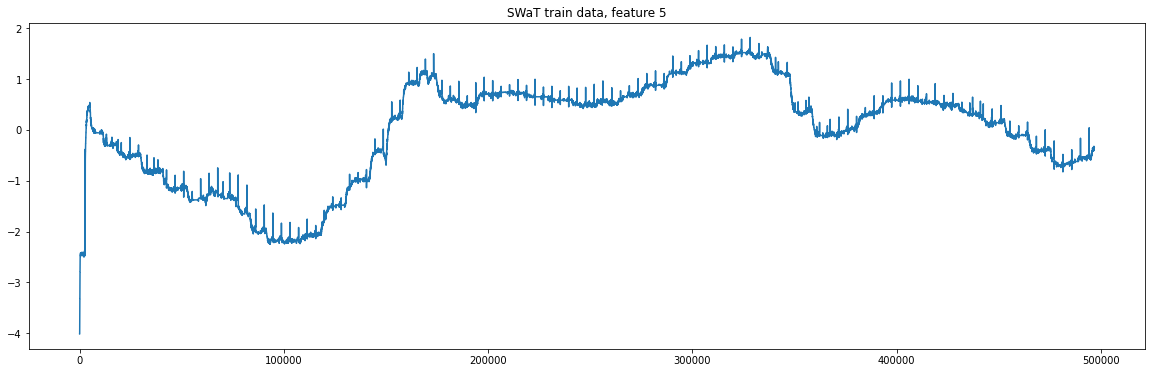

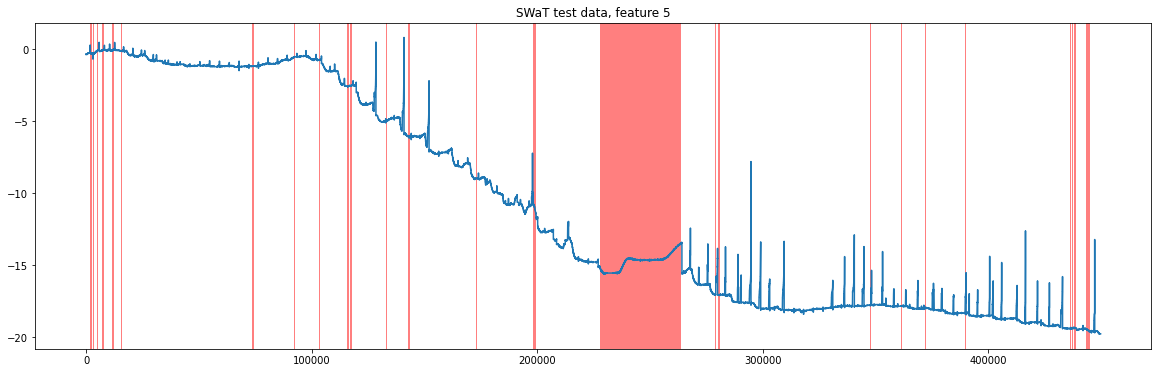

In [5]:
C = 5
dataset = "SWaT"
datafactory.visualize_dataset(train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y, dataset_name=dataset, feature_idx=C)

## Train Model

In [6]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_size, latent_space_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, input_size // 2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(input_size // 2, input_size // 4)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(input_size // 4, latent_space_size)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        out = self.relu3(x)
        return out

class Decoder(nn.Module):
    def __init__(self, input_size, latent_space_size):
        super().__init__()
        self.linear1 = nn.Linear(latent_space_size, input_size // 4)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(input_size // 4, input_size // 2)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(input_size // 2, input_size)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        out = self.linear3(x)
        return out
    
class AnomalyScorer(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)
        
    def forward(self, X, Xhat):
        e = (Xhat-X)**2
        a = torch.sigmoid(self.linear(e))
        return a
        

class MLP(nn.Module):
    def __init__(self, seq_len, num_channels, latent_space_size):
        super().__init__()
        self.encoder = Encoder(seq_len*num_channels, latent_space_size)
        self.decoder = Decoder(seq_len*num_channels, latent_space_size)
        self.anosc = AnomalyScorer(num_channels)

    def forward(self, X):
        B, L, C = X.shape
        z = self.encoder(X.reshape(B, L*C))
        Xhat = self.decoder(z).reshape(B, L, C)
        anosc = self.anosc(X, Xhat)
        return Xhat, anosc

In [7]:
X = torch.randn((64, 12, 51)).to(args.device)
B, L, C = X.shape

In [8]:
model = MLP(seq_len=12, num_channels=51, latent_space_size=128).to(args.device)
Xhat, anosc =  model(X)
(Xhat.shape, anosc.shape)

(torch.Size([64, 12, 51]), torch.Size([64, 12, 1]))

### train AE first

In [9]:
train_iterator = tqdm(
    train_loader,
    total=len(train_loader),
    desc="calculating reconstruction errors",
    leave=True
)

EPOCHS = 5
optimizer = torch.optim.Adam(
    params=
    [p for p in model.encoder.parameters()]+
    [p for p in model.decoder.parameters()], 
    lr=args.lr
)
for i in range(EPOCHS):
    model.train()
    train_summary = 0.0
    for i, batch_data in enumerate(train_iterator):
        X = batch_data[0].to(args.device)
        B, L, C = X.shape

        # recon
        Xhat, anosc = model(X)

        # optimize
        optimizer.zero_grad()
        loss = F.mse_loss(Xhat, X)
        loss.backward()
        optimizer.step()
        
        train_summary += loss.item()
    train_summary /= len(train_loader)
    print(train_summary)

calculating reconstruction errors: 100%|██████████| 7763/7763 [00:36<00:00, 213.23it/s]


0.0313312348996474
0.013262702836573501
0.009886488789533202
0.007890194215106729
0.006860348128306491


### Training statistics

In [10]:
train_iterator = tqdm(
    train_loader,
    total=len(train_loader),
    desc="calculating reconstruction errors",
    leave=True
)

recon_errors = []
with torch.no_grad():
    for i, batch_data in enumerate(train_iterator):
        X = batch_data[0].to(args.device)
        B, L, C = X.shape
        Xhat, anosc = model(X.reshape(B, L, C))
        recon_error = torch.nn.functional.mse_loss(Xhat, X, reduction='none')
        recon_errors.append(recon_error)

recon_errors = torch.cat(recon_errors, axis=0)

train_error_dist = recon_errors.mean(dim=(1, 2))

print(f"{recon_errors.shape}, {train_error_dist.shape}")

calculating reconstruction errors: 100%|██████████| 7763/7763 [00:13<00:00, 579.27it/s]

torch.Size([496789, 12, 51]), torch.Size([496789])


In [11]:
th_q95 = torch.quantile(train_error_dist, 0.95).item()
th_q99 = torch.quantile(train_error_dist, 0.99).item()
th_q100 = torch.max(train_error_dist).item()
th_q95, th_q99, th_q100

(0.018097836524248123, 0.185616597533226, 6.103304386138916)

In [80]:
train_iterator = tqdm(
    train_loader,
    total=len(train_loader),
    desc="calculating reconstruction errors",
    leave=True
)

as_optimizer = torch.optim.Adam(
    params=model.parameters(), 
    lr=args.lr
)
bce = torch.nn.BCELoss()

for i in range(EPOCHS):
    model.train()
    train_summary = 0.0
    for i, batch_data in enumerate(train_iterator):
        X = batch_data[0].to(args.device)
        B, L, C = X.shape

        # recon
        Xhat, yhat = model(X)
        E = F.mse_loss(Xhat, X, reduction='none').mean(dim=2, keepdim=True)
        ytilde = (E > th_q95).float()
        

        # optimize
        as_optimizer.zero_grad()
        loss = bce(yhat, ytilde)
        loss.backward()
        as_optimizer.step()
        
        train_summary += loss.item()
    train_summary /= len(train_loader)
    print(train_summary)

calculating reconstruction errors: 100%|██████████| 7763/7763 [00:23<00:00, 326.35it/s]


0.01618983865006904
0.008491444602369282
0.006500592405726161
0.005546203092558147
0.004973624844480392


## Test: static threshold inference

In [81]:
eval_iterator = tqdm(
    test_loader,
    total=len(test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

anoscs_prev = []
Xhats_prev = []
with torch.no_grad():
    for i, batch_data in enumerate(eval_iterator):
        X, y = batch_data[0].to(args.device), batch_data[1].to(args.device)
        B, L, C = X.shape
        Xhat, yhat = model(X)
        Xhats_prev.append(Xhat)        
        anoscs_prev.append(yhat>0.5)

Xhats_prev = torch.cat(Xhats_prev, axis=0).detach().cpu().numpy()
anoscs_prev = torch.cat(anoscs_prev, axis=0).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [00:28<00:00, 1303.08it/s]


In [84]:
print(get_summary_stats(test_dataset.y, anoscs_prev))

{'Accuracy': 0.31535219907716106, 'Precision': 0.1460373500773704, 'Recall': 0.9578631100688847, 'F1': 0.2534355141274157, 'tn': 89598, 'fp': 305734, 'fn': 2300, 'tp': 52284}


## Single-model

In [ ]:
## v3
eval_iterator = tqdm(
    test_loader,
    total=len(test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
pi = 0.05
t = 100

TT_optimizer = torch.optim.SGD([theta]+[p for p in source_model.parameters()], lr=lr)

bce = torch.nn.BCELoss()

Xs = []
Xhats = []
yhats = []
thetas = []
preds = []


for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(args.device), batch_data[1].to(args.device)
    B, L, C = X.shape
    Xs.append(X)
    
    # target model inference
    with torch.no_grad():
        Xhatp, yhatp = target_model(X)
        
    
    # source model inference
    Xhat, yhat = smodel(X)
    ytilde = (yhatp > theta)
    
    # threshold
    pred = (yhat > theta)
    
    # log source model outputs
    Xhats.append(Xhat)
    preds.append(pred)
    thetas.append(theta.item())
    
    # update model
    TT_optimizer.zero_grad()
    recon_loss = (F.mse_loss(Xhat, X, reduction="none")*~ytilde).mean()
    theta_loss = 0.5*(((torch.clamp(yhat-theta, min=0))**2).mean() + pi*(theta**2))
    loss = recon_loss + theta_loss
    loss.backward()
    TT_optimizer.step()
    
    # EMA
    ema_updater.update(1)
    
    
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(As, axis=0).reshape(-1).detach().cpu().numpy()
thrs = np.repeat(np.array(torch.stack(thrs).detach().cpu().numpy()), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

## EMA

In [85]:
import torch
import copy
from utils.tools import set_requires_grad

def set_requires_grad(model, val):
    for p in model.parameters():
        p.requires_grad = val
        
class EMAUpdater:
    def __init__(self, source_model, target_model, moving_average_decay, start_iter=0):
        super().__init__()
        self.source_model = source_model
        self.target_model = target_model
        self.moving_average_decay = moving_average_decay
        self.start_iter = start_iter

        set_requires_grad(self.target_model, False)
        self._update_moving_average(0.0)

    def _update_moving_average(self, moving_average_decay):
        with torch.no_grad():
            for target_params, source_params in zip(self.target_model.parameters(), self.source_model.parameters()):
                target_params.copy_(source_params.lerp(target_params, moving_average_decay))
            for target_buffers, source_buffers in zip(self.target_model.buffers(), self.source_model.buffers()):
                target_buffers.copy_(source_buffers)
    
    def update(self, iter_count):
        if iter_count < self.start_iter:
            self._update_moving_average(0.0)
        else:
            self._update_moving_average(self.moving_average_decay)

## Value-based Pseudo-label guided Online Learning

In [92]:
theta = torch.tensor(0.5, requires_grad=True, device=args.device)
theta

tensor(0.5000, device='cuda:0', requires_grad=True)

In [93]:
pretrained_model = model
source_model = copy.deepcopy(pretrained_model)
target_model = copy.deepcopy(pretrained_model)
ema_updater = EMAUpdater(source_model, target_model, 0.99)

In [94]:
## v3
eval_iterator = tqdm(
    test_loader,
    total=len(test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
pi = 0.05
t = 100

TT_optimizer = torch.optim.SGD([theta]+[p for p in source_model.parameters()], lr=lr)

bce = torch.nn.BCELoss()

Xs = []
Xhats = []
yhats = []
thetas = []
preds = []


for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(args.device), batch_data[1].to(args.device)
    B, L, C = X.shape
    Xs.append(X)
    
    # target model inference
    with torch.no_grad():
        Xhatp, yhatp = target_model(X)
        ytilde = (yhatp > theta)
    
    # source model inference
    Xhat, yhat = source_model(X)
    
    # threshold
    pred = (yhat > theta)
    
    # log source model outputs
    Xhats.append(Xhat)
    preds.append(pred)
    thetas.append(theta.item())
    
    # update model
    TT_optimizer.zero_grad()
    recon_loss = (F.mse_loss(Xhat, X, reduction="none")*~ytilde).mean()
    theta_loss = 0.5*(((torch.clamp(yhat-theta, min=0))**2).mean() + pi*(theta**2))
    loss = recon_loss + theta_loss
    loss.backward()
    TT_optimizer.step()
    
    # EMA
    ema_updater.update(1)
    
    
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(As, axis=0).reshape(-1).detach().cpu().numpy()
thrs = np.repeat(np.array(torch.stack(thrs).detach().cpu().numpy()), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [03:04<00:00, 203.71it/s]


NameError: name 'As' is not defined

In [95]:
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

In [41]:
torch.stack(thrs).shape

torch.Size([37493])

In [96]:
print(test_y.shape, preds.shape)
get_summary_stats(test_y, preds)

(449916,) (449916,)


{'Accuracy': 0.3440108820313125,
 'Precision': 0.15118207971787853,
 'Recall': 0.9550417704821926,
 'F1': 0.2610415623435153,
 'tn': 102646,
 'fp': 292686,
 'fn': 2454,
 'tp': 52130}

## Anomaly score plot

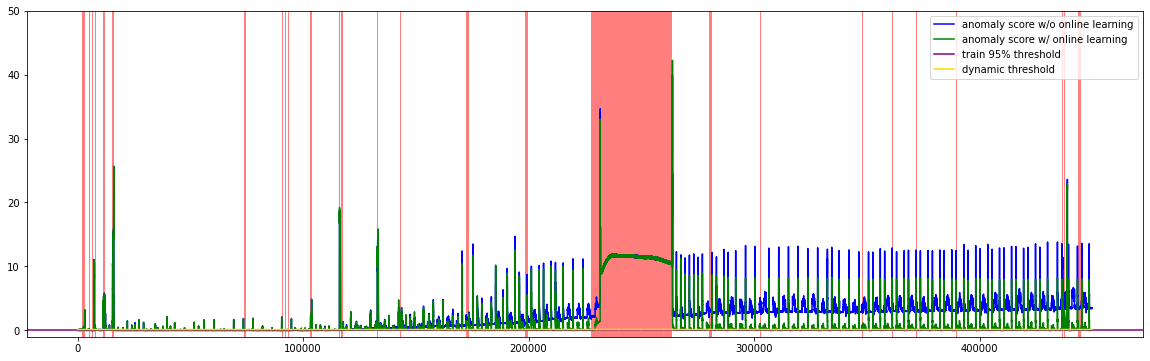

In [44]:
#ax[5].set_ylim([-1, 20])
plt.figure(figsize=(20, 6))
plt.ylim([-1, 50])
plt.plot(anoscs_prev, color="blue", label="anomaly score w/o online learning")
plt.plot(anoscs, color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="purple", label="train 95% threshold")
plt.plot(thrs, color="gold",label="dynamic threshold")
plt.legend()
plot_anomaly(plt, test_y)

plt.show()

In [45]:
s, e = None, None
for i in range(len(test_y)):
    if test_y[i] == 1 and s is None:
        s = i
    elif test_y[i] == 0 and s is not None:
        e = i - 1
        print(f"[{s}, {e}], {preds[s:e].sum()} / {e-s+1}")
        s, e = None, None

[1754, 2693], 939 / 940
[3068, 3510], 442 / 443
[4920, 5302], 382 / 383
[6459, 6848], 389 / 390
[7255, 7450], 195 / 196
[7705, 8133], 428 / 429
[11410, 12373], 963 / 964
[15380, 16100], 720 / 721
[73800, 74520], 720 / 721
[90685, 90917], 232 / 233
[92140, 92570], 430 / 431
[93445, 93720], 275 / 276
[103092, 103808], 716 / 717
[115843, 116101], 258 / 259
[116143, 116537], 394 / 395
[117000, 117720], 720 / 721
[132918, 133380], 462 / 463
[142954, 143650], 696 / 697
[172305, 172588], 283 / 284
[172910, 173521], 611 / 612
[198296, 199740], 192 / 1445
[227828, 263727], 34208 / 35900
[279120, 279240], 0 / 121
[280060, 281230], 0 / 1171
[302653, 303019], 0 / 367
[347679, 348279], 0 / 601
[361191, 361634], 154 / 444
[371479, 371579], 0 / 101
[371855, 372335], 109 / 481
[389680, 390219], 46 / 540
[436541, 437009], 468 / 469
[437417, 437697], 242 / 281
[438147, 438547], 363 / 401
[438621, 438917], 258 / 297
[443501, 445190], 51 / 1690


## With time series

In [ ]:
# plot abnormal
test_X, test_y = test_dataset.X, test_dataset.y

B, L, C = Xhats.shape

fig, ax = plt.subplots(6, 1, figsize=(20, 30))

for c in range(min(args.num_channels, 5)):
    # gt
    ax[c].plot(test_X[:, c], color="black", label="gt")
    plot_anomaly(ax[c], test_y)
    
    # reconed
    ax[c].plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed w/o online learning")
    ax[c].plot(Xhats[:,:,c].reshape(-1), linewidth=0.5, color="green", label="reconed w/ online learning")
    ax[c].legend()

#ax[5].set_ylim([-1, 20])
ax[5].plot(anoscs_prev.reshape(-1), color="blue", label="anomaly score w/o online learning")
ax[5].plot(anoscs.reshape(-1), color="green", label="anomaly score w/ online learning")
ax[5].axhline(th_q95, color="purple", label="train 95% threshold")
ax[5].axhline(th_best_static, color="black", label="oracle threshold")
ax[5].plot(thrs, color="gold",label="dynamic threshold")
ax[5].legend()
plot_anomaly(ax[5], test_y)

plt.show()

### Label-guided Online learning

In [ ]:
init_thr = torch.quantile(train_error_dist, 0.95).item()
thr = torch.tensor(init_thr, requires_grad=True)
thr

In [ ]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
TH_optimizer = torch.optim.SGD([thr]+[p for p in tester.model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs = []
Xhats = []
yhats = []
anoscs=[]
thrs = []
preds = []
for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    Xs.append(X)
    
    # infer
    B, L, C = X.shape
    Xhat = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
    Xhats.append(Xhat)
    
    e = F.mse_loss(Xhat, X, reduction='none')
    anosc = e.mean(dim=2)
    anoscs.append(anosc)
    thrs.append(thr.item())
    pred = (anosc > thr)
    preds.append(pred)
    
    # update
    TH_optimizer.zero_grad()
    yhat = torch.sigmoid(anosc-thr)
    yhats.append(yhat)
    cls_loss = bce(yhat, y.float())
    mask = ((y == 0).unsqueeze(2))
    recon_loss = (e*mask).mean()
    loss = cls_loss + recon_loss
    loss.backward()
    TH_optimizer.step()
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()
yhats = torch.cat(yhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(anoscs, axis=0).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

In [ ]:
print(test_y.shape, preds.shape)
get_summary_stats(test_y, preds)

In [ ]:
# plot abnormal
test_X, test_y = test_dataset.X, test_dataset.y

B, L, C = Xhats.shape

fig, ax = plt.subplots(6, 1, figsize=(20, 30))

for c in range(min(args.num_channels, 5)):
    # gt
    ax[c].plot(test_X[:, c], color="black", label="gt")
    plot_anomaly(ax[c], test_y)
    
    # reconed
    ax[c].plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed w/o online learning")
    ax[c].plot(Xhats[:,:,c].reshape(-1), linewidth=0.5, color="green", label="reconed w/ online learning")
    ax[c].legend()

#ax[5].set_ylim([-1, 20])
ax[5].plot(anoscs_prev.reshape(-1), color="blue", label="anomaly score w/o online learning")
ax[5].plot(anoscs.reshape(-1), color="green", label="anomaly score w/ online learning")
ax[5].axhline(th_q95, color="purple", label="train 95% threshold")
ax[5].axhline(th_best_static, color="black", label="oracle threshold")
ax[5].plot(thrs, color="gold",label="dynamic threshold")
ax[5].legend()
plot_anomaly(ax[5], test_y)

plt.show()

In [ ]:
c=5
plt.figure(figsize=(20, 6))
plt.title(f"{args.dataset}, channel {c}")
plt.plot(train_X[:, c], label="train", color="#1f77b4")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], label="test", color="#ff7f0e")
lb = np.concatenate([np.zeros(len(train_X)), test_y])
plot_anomaly(plt, lb)
plt.legend()
plt.show()

In [ ]:
c=7
plt.figure(figsize=(20, 6))
#plt.ylim(-6, 6)
plt.title(f"{args.dataset}, channel {c}")

plt.plot(train_X[:, c], label="train", color="#1f77b4")
plt.axhline(train_X[100000:, c].mean(), color = 'r', label="mean of train data")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], label="test", color="#ff7f0e")

lb = np.concatenate([np.zeros(len(train_X)), test_y])
plot_anomaly(plt, lb)
plt.legend()
plt.show()

In [ ]:
C = 7
for c in range(args.num_channels):
    plt.figure(figsize=(20, 6))
    plt.title(f"{args.dataset}, channel {c}, train")
    plt.plot(train_X[:, c], label="train", color="#1f77b4")
    plt.legend()
    plt.show()

    plt.figure(figsize=(20, 6))
    plt.title(f"{args.dataset}, channel {c}, test")
    plt.plot(test_X[:, c], label="test", color="#ff7f0e")
    plot_anomaly(plt, test_y)
    plt.legend()
    plt.show()